<a href="https://colab.research.google.com/github/jakedorman64/internship/blob/main/Regression_with_Haiku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Important links:
https://github.com/deepmind/dm-haiku/blob/main/examples/mnist.py
https://notebook.community/deepmind/dm-haiku/examples/haiku_lstms

In [240]:
!pip install git+https://github.com/deepmind/dm-haiku

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-efd_joxc
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-efd_joxc
  Resolved https://github.com/deepmind/dm-haiku to commit 4b0401225221c2fba092903edfab15fc6e102642
  Preparing metadata (setup.py) ... done


In [420]:
from typing import Iterator, NamedTuple

from absl import app
import haiku as hk
import jax
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import value_and_grad, jit, vmap, grad, random
from jax.numpy import pi, sin, cos
import time
import numpy as np
import optax
from sklearn.model_selection import train_test_split

In [421]:
# Create our random keys
key, subkey = random.split(random.PRNGKey(int(time.time())))
gradient_updates = 15000
datapoints = 1024
batch_size = 8

# Make a function to initialise our data.
def generate_data(t):
  return t + sin(t) + 0.3 * random.normal(subkey, shape=(datapoints,))

# Generate inputs and targets
x_truth = random.uniform(key, minval=0, maxval=10, shape=(datapoints,))
y_truth = generate_data(x_truth)

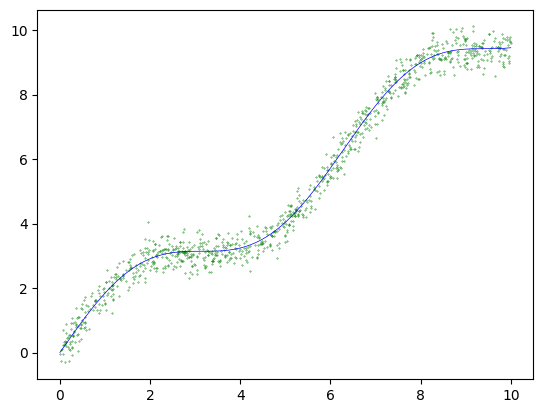

In [422]:
# Graph targets against actual curve.
plt.scatter(x_truth, y_truth, s=0.1, color='green')
fine_inputs = jnp.reshape(jnp.linspace(0, 10, 1000), (1000, 1))
plt.plot(fine_inputs, fine_inputs + sin(fine_inputs), lw=0.5, color='blue')

In [423]:
# Normalise our data:
x_truth = (x_truth - jnp.mean(x_truth)) / jnp.std(x_truth)
y_truth = (y_truth - jnp.mean(y_truth)) / jnp.std(y_truth)

# Normalise data between 0 and 1:
# x_truth = (x_truth - jnp.min(x_truth)) / (jnp.max(x_truth) - jnp.min(x_truth))
# y_truth = (y_truth - jnp.min(y_truth)) / (jnp.max(y_truth) - jnp.min(y_truth))

# Split the data:
x_train, x_test, y_train, y_test = train_test_split(x_truth, y_truth, random_state=42)

# Data needs to be in this format to go into the model.
x_train = x_train.reshape(len(x_train),1)
x_test = x_test.reshape(len(x_test),1)

In [424]:
# Define our dataset class. This allows us to batch our data when training.
class Dataset:
  """An iterator over a numpy array, revealing batch_size elements at a time."""
  # Initialise our dataset class. It needs the full x and y values and a batch size to be initialised.
  def __init__(self, x: jnp.array, y: jnp.array, batch_size: int):
    self._x = x
    self._y = y
    self._batch_size = batch_size
    self._length = self._x.shape[0]
    # The id stores where the next datapoint should be taken from, so when initialised it should be 0.
    self._idx = 0
    if self._length % batch_size != 0:
      msg = 'dataset size {} must be divisible by batch_size {}.'
      raise ValueError(msg.format(self._length, batch_size))

  # This is the function that gives us our next batch of data.
  def __next__(self):
    # Select the first and last datapoints in the batch. First will be the current value of the ID
    start = self._idx
    end = start + self._batch_size
    # Select our data.
    x, y = self._x[start:end], self._y[start:end]
    # This resets us back to 0 once we reach the end of our data.
    if end >= self._length:
      end = end % self._length
      # assert end == 0  # Guaranteed by ctor assertion.
    self._idx = end
    return x, y

In [425]:
# Now that we have defined our dataset class, we can make our datasets:
train_dataset = Dataset(x_train, y_train, batch_size)
eval_dataset = Dataset(x_test, y_test, batch_size)

In [426]:
# Define a batch of data.
class Batch(NamedTuple):
  input: np.ndarray
  output: np.ndarray

# Define a training state, telling us what parameters we have and the state of the optimizer.
class TrainingState(NamedTuple):
  params: hk.Params
  opt_state: optax.OptState

In [427]:
# Define the neural network.
def FeedForward(x):
  mlp = hk.Sequential([
      hk.Linear(10), jax.nn.relu,
      hk.Linear(10), jax.nn.relu,
      hk.Linear(1),
  ])
  return mlp(x)

# Define our network and optimiser.
network = hk.without_apply_rng(hk.transform(FeedForward))
optimiser = optax.adam(1e-3)

In [428]:
# Define our mean squared error loss.
@jax.jit
def MeanSquaredErrorLoss(weights, batch):
  preds = network.apply(weights, batch[0])

  # This removes the fact that it is an array of arrays.
  preds = preds.squeeze()
  return jnp.power(batch[1] - preds, 2).mean()

In [429]:
@jax.jit
def update(state: TrainingState, batch: Batch) -> TrainingState:
  # This is how we define our stochastic gradient descent.

  # Find grads of loss w.r.t parameters, on this batch of the data.
  grads = jax.grad(MeanSquaredErrorLoss)(state.params, batch)
  # Get the updates and the new optimser state from this.
  updates, opt_state = optimiser.update(grads, state.opt_state)
  # Apply the updates to the parameters.
  params = optax.apply_updates(state.params, updates)

  #return the training state with the new parameters and the optimiser.
  return TrainingState(params, opt_state)


In [430]:
#Initialising the parameters randomly.
rng = jax.random.PRNGKey(11)
initial_params = network.init(rng, x_train[:1])


# Initialise the optimiser and the define the state.
initial_opt_state = optimiser.init(initial_params)
state = TrainingState(initial_params, initial_opt_state)

# Print the structure of the network.
print("Weights Type : {}\n".format(type(initial_params)))

for layer_name, weights in initial_params.items():
    print(layer_name)
    print("Weights : {}, Biases : {}\n".format(initial_params[layer_name]["w"].shape,initial_params[layer_name]["b"].shape))


Weights Type : <class 'dict'>

linear
Weights : (1, 10), Biases : (10,)

linear_1
Weights : (10, 10), Biases : (10,)

linear_2
Weights : (10, 1), Biases : (1,)



Step 0: train loss 1.1785253286361694, eval loss 1.317291498184204
Step 1000: train loss 0.023518793284893036, eval loss 0.03628837317228317
Step 2000: train loss 0.01928454451262951, eval loss 0.0181443989276886
Step 3000: train loss 0.026834597811102867, eval loss 0.0143900690600276
Step 4000: train loss 0.006487344857305288, eval loss 0.02086426503956318
Step 5000: train loss 0.01447302009910345, eval loss 0.007930321618914604
Step 6000: train loss 0.005537926219403744, eval loss 0.02021309919655323
Step 7000: train loss 0.016594506800174713, eval loss 0.018777787685394287
Step 8000: train loss 0.01376647874712944, eval loss 0.005410422571003437
Step 9000: train loss 0.006459939293563366, eval loss 0.004264172166585922
Step 10000: train loss 0.018934454768896103, eval loss 0.013445653021335602
Step 11000: train loss 0.004968824330717325, eval loss 0.01055715512484312
Step 12000: train loss 0.014682638458907604, eval loss 0.01113840565085411
Step 13000: train loss 0.01108055189251899

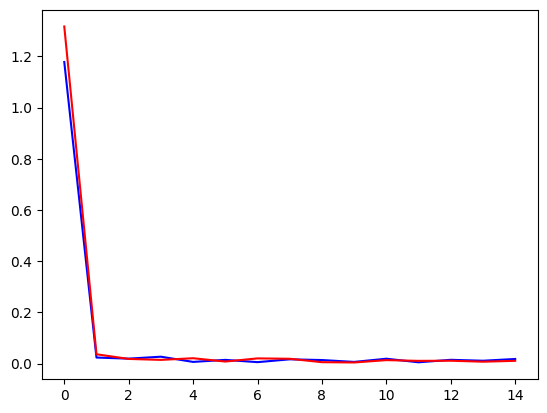

In [431]:
# Training & evaluation loop.
train_loss_list = []
val_loss_list = []
for step in range(gradient_updates):
  # Do stochastic gradient descent on a batch of training examples.
  state = update(state, next(train_dataset))

  # Print the training and evaluation loss every 1000 time steps.
  if step % 1000 == 0:
    train_loss_list.append(MeanSquaredErrorLoss(state.params, next(train_dataset)))
    val_loss_list.append(MeanSquaredErrorLoss(state.params, next(eval_dataset)))
    print("Step {}: train loss {}, eval loss {}".format(step, train_loss_list[-1], val_loss_list[-1]))

plt.plot(train_loss_list, color="b")
plt.plot(val_loss_list, color="red")

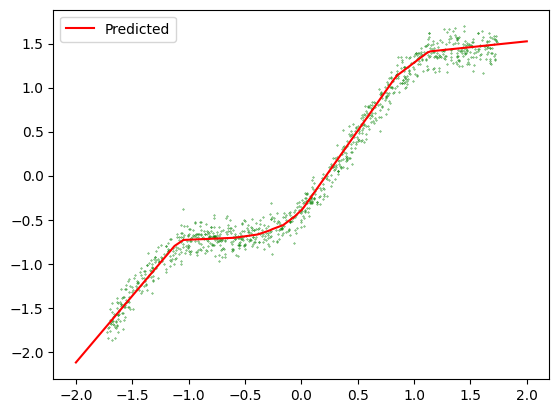

In [432]:
# Graph our prediction against the actual curve and the testing data
plt.scatter(x_truth, y_truth, s=0.1, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-2, 2, 10000), (10000, 1))
plt.plot(fine_inputs, network.apply(state.params, fine_inputs), color='red', label="Predicted")
plt.legend()